In [114]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold

## Read and format dataset

In [116]:
def get_data():
    # dataset from https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt
    df = pd.read_csv('fruit.txt', sep='\t')
    # Randomize the order
    df = df.sample(frac=1).reset_index(drop=True)
    target = df["fruit_label"]
    data = df.iloc[:,3:]
    #size = int(df.shape[0] * 0.1)
    size = 10
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = size, random_state = 0)
    print(f"Training set size: {x_train.shape[0]}, Test set size: {x_test.shape[0]}")
    x_train = np.array(x_train.values)
    x_test = np.array(x_test.values)
    y_train = np.array(y_train.values)
    y_test = np.array(y_test.values)
    return x_train, x_test, y_train, y_test

## Machine Learning algorithms as functions to enable parameter tuning

In [117]:
# Logistic regression
def run_log_reg(C, max_iterations, x_train, y_train, x_val, y_val):
    log_reg = LogisticRegression(solver="lbfgs", max_iter=max_iterations, multi_class="auto", C = C)
    log_reg.fit(x_train, y_train)
    train_score = log_reg.score(x_train, y_train)
    val_score = log_reg.score(x_val, y_val)
    return train_score, val_score

In [118]:
# SVM max margin classification
def run_svc(C, gamma, x_train, y_train, x_val, y_val):
    clf = svm.SVC(gamma=gamma, C = C)#kernel='poly',degree = 3, gamma='scale')
    clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    val_score = clf.score(x_val, y_val)
    return train_score, val_score

In [119]:
# Decision Tree
def run_tree(max_depth, x_train, y_train, x_val, y_val):
    clf = tree.DecisionTreeClassifier(splitter="random", max_depth=max_depth)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    val_score = clf.score(x_val, y_val)
    tree.plot_tree(clf)
    return train_score, val_score

In [125]:
global_tests = []
global_param1 = []
global_param2 = []

Training set size: 49, Test set size: 10
[0.6757070707070707, 0.6757070707070707, 0.7618686868686869, 0.7822727272727273, 0.7868181818181819, 0.789090909090909, 0.789090909090909, 0.7913131313131312, 0.7958585858585858, 0.8003535353535354, 0.8004040404040405, 0.7958585858585858, 0.7958585858585858, 0.7958585858585858, 0.7958585858585858, 0.7958585858585858, 0.7958585858585858]
[0.625, 0.625, 0.6849999999999999, 0.73, 0.73, 0.73, 0.7699999999999999, 0.7699999999999999, 0.7699999999999998, 0.7899999999999998, 0.7899999999999998, 0.7499999999999999, 0.7699999999999999, 0.7699999999999999, 0.7699999999999999, 0.7499999999999999, 0.7699999999999999]
0.8
10000
0.8444444444444444 0.7
Best C: 0.8
Best validation performance: 0.7899999999999998
Test performance: 0.7


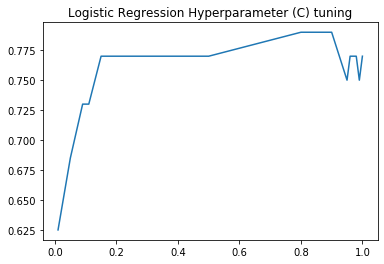

Over 2 trials, average test score: 0.7, average C: 0.8


In [127]:
# Hyperparameter Tuning
x_rest, x_test, y_rest, y_test = get_data()

Cs = [0.01, 0.01, 0.05, 0.09, 0.1, 0.11, 0.15, 0.2, 0.5, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
max_iters_tuning = [10000]
train_scores = []
val_scores = []
max_train = 0
max_val = 0
best_C = 0
best_iters = 0
splits = 10
for C in Cs:
    for max_iters in max_iters_tuning:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(x_rest)
        split_train_scores = []
        split_val_scores = []
        for train_index, val_index in kf.split(x_rest):
            x_train, x_val = x_rest[train_index], x_rest[val_index]
            y_train, y_val = y_rest[train_index], y_rest[val_index]
            train_score, val_score = run_log_reg(C, max_iters, x_train, y_train, x_val, y_val)
            split_train_scores.append(train_score)
            split_val_scores.append(val_score)
        train_score = sum(split_train_scores) / len(split_train_scores)
        val_score = sum(split_val_scores) / len(split_val_scores)
        train_scores.append(train_score)
        val_scores.append(val_score)
        if val_score > max_val:
            best_C = C
            best_iters = max_iters
            max_val = val_score
            
print(train_scores)
print(val_scores)
print(best_C)
print(best_iters)
train_score, test_score = run_log_reg(best_C, best_iters, x_train, y_train, x_test, y_test)
print(train_score, test_score)
print(f"Best C: {best_C}")
print(f"Best validation performance: {max_val}")
print(f"Test performance: {test_score}")
plt.plot(Cs, val_scores)
plt.title("Logistic Regression Hyperparameter (C) tuning")
plt.show()
global_tests.append(test_score)
global_param1.append(best_C)
print(f"Over {len(global_tests)} trials, average test score: {sum(global_tests) / len(global_tests)}, average C: {sum(global_param1) / len(global_param1)}")

In [67]:
# Hyperparameter Tuning
x_rest, x_test, y_rest, y_test = get_data()

gammas = [0.1, 0.2, 0.5, 0.9, 1]
#gammas = [0.2]
Cs = [0.01, 0.01, 0.05, 0.09, 0.1, 0.11, 0.15, 0.2, 0.5, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
#Cs = [0.95]
train_scores = []
val_scores = []
max_train = 0
max_val = 0
best_C = 0
best_gamma = 0
splits = 10
for gamma in gammas:
    for C in Cs:
        kf = KFold(n_splits=splits)
        kf.get_n_splits(x_rest)
        split_train_scores = []
        split_val_scores = []
        for train_index, val_index in kf.split(x_rest):
            x_train, x_val = x_rest[train_index], x_rest[val_index]
            y_train, y_val = y_rest[train_index], y_rest[val_index]
            train_score, val_score = run_svc(C, gamma, x_train, y_train, x_val, y_val)
            split_train_scores.append(train_score)
            split_val_scores.append(val_score)
        train_score = sum(split_train_scores) / len(split_train_scores)
        val_score = sum(split_val_scores) / len(split_val_scores)
        train_scores.append(train_score)
        val_scores.append(val_score)
        if val_score > max_val:
            best_gamma = gamma
            best_C = C
            max_val = val_score

print(train_scores)
print(val_scores)
train_score, test_score = run_svc(best_C, best_gamma, x_train, y_train, x_test, y_test)
print(train_score, test_score)
print(f"Best gamma: {best_gamma}")
print(f"Best C: {best_C}")
print(f"Best validation performance: {max_val}")
print(f"Test performance: {test_score}")
#plt.plot(Cs, val_scores)
#plt.title("SVC Hyperparameter (C, gamma = 0.2) tuning")
#plt.show()

Training set size: 54, Test set size: 5
[0.4421343537414967, 0.4421343537414967, 0.4421343537414967, 0.4421343537414967, 0.4421343537414967, 0.4421343537414967, 0.47287414965986396, 0.5372448979591837, 0.7548044217687073, 0.857780612244898, 0.8660714285714285, 0.868154761904762, 0.8701955782312926, 0.8701955782312926, 0.8701955782312926, 0.8722789115646258, 0.8722789115646258, 0.48741496598639455, 0.48741496598639455, 0.48741496598639455, 0.48741496598639455, 0.48741496598639455, 0.48741496598639455, 0.49774659863945575, 0.5554846938775511, 0.7712159863945578, 0.9114795918367348, 0.9217261904761903, 0.9238095238095239, 0.9238095238095239, 0.9258503401360544, 0.9258503401360544, 0.9258503401360544, 0.9278911564625851, 0.5017857142857143, 0.5017857142857143, 0.5017857142857143, 0.5017857142857143, 0.5017857142857143, 0.5017857142857143, 0.5017857142857143, 0.5182397959183673, 0.7938350340136054, 0.9525935374149659, 0.9546343537414966, 0.9587585034013605, 0.9587585034013605, 0.95875850340

Training set size: 54, Test set size: 5
[0.49774659863945575, 0.6601190476190476, 0.7116921768707483, 0.8436649659863946, 0.8829081632653061, 0.9463860544217686, 0.9711734693877551, 0.9938775510204081, 0.9896683673469389, 1.0]
[0.38666666666666666, 0.40666666666666673, 0.6333333333333332, 0.6866666666666666, 0.8133333333333332, 0.8033333333333333, 0.8333333333333334, 0.8133333333333332, 0.9100000000000001, 0.7933333333333332]
1.0 0.8
Best max depth: 9
Best validation performance: 0.9100000000000001
Test performance: 0.8


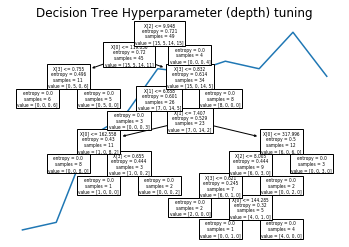

In [69]:
# Hyperparameter Tuning
x_rest, x_test, y_rest, y_test = get_data()

depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores = []
val_scores = []
max_train = 0
max_val = 0
best_depth = 0
splits = 10
for depth in depths:
    kf = KFold(n_splits=splits)
    kf.get_n_splits(x_rest)
    split_train_scores = []
    split_val_scores = []
    for train_index, val_index in kf.split(x_rest):
        x_train, x_val = x_rest[train_index], x_rest[val_index]
        y_train, y_val = y_rest[train_index], y_rest[val_index]
        train_score, val_score = run_tree(depth, x_train, y_train, x_val, y_val)
        split_train_scores.append(train_score)
        split_val_scores.append(val_score)
    train_score = sum(split_train_scores) / len(split_train_scores)
    val_score = sum(split_val_scores) / len(split_val_scores)
    train_scores.append(train_score)
    val_scores.append(val_score)
    if val_score > max_val:
        best_depth = depth
        max_val = val_score

print(train_scores)
print(val_scores)
train_score, test_score = run_tree(best_depth, x_train, y_train, x_test, y_test)
print(train_score, test_score)
print(f"Best max depth: {best_depth}")
print(f"Best validation performance: {max_val}")
print(f"Test performance: {test_score}")
plt.plot(depths, val_scores)
plt.title("Decision Tree Hyperparameter (depth) tuning")
plt.show()

In [ ]:
#Split data into targets and labels for our trainings, validation, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(0.8, 0.1, 0.1, df)


In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='poly',degree = 3, gamma='scale')
clf.fit(x_train, y_train)
clf.predict(x_test)
print(clf.score(x_test, y_test))
print(clf.score(x_val, y_val))
print(clf.score(x_train, y_train))

In [ ]:
def split_dataset(train_size, val_size, test_size, dataset):
    #Split data into targets and labels for our trainings, validation, and test sets
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    data = dataset.iloc[:,:-1]
    target = df.iloc[:,-1]
    x_train, x_val, x_test = np.split(data.sample(frac=1), [int(train_size*len(df)), int(1-val_size*len(df))])
    y_train, y_val, y_test = np.split(target.sample(frac=1), [int(train_size*len(df)), int(1-val_size*len(df))])
    #print(x_train.shape, x_val.shape, x_test.shape)
    #print(y_train.shape, y_val.shape, y_test.shape)
    return x_train, y_train, x_val, y_val, x_test, y_test
    

In [113]:
print(f"Most common target is {df.fruit_label.mode()[0]} or {df.fruit_label.mode()[1]} (tied)")
print(f"Accuracy of majority guess is {df.fruit_label.value_counts().max()} / {df.shape[0]} = {df.fruit_label.value_counts().max() / df.shape[0]}")

Most common target is 1 or 3 (tied)
Accuracy of majority guess is 19 / 59 = 0.3220338983050847
